In [26]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.preprocessing import LabelEncoder, StandardScaler, PowerTransformer, KBinsDiscretizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score

from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE
from collections import Counter

from pgmpy.models import BayesianNetwork
from pgmpy.estimators import BayesianEstimator
from pgmpy.inference import VariableElimination

import warnings
warnings.filterwarnings("ignore")


In [27]:
!pip install ucimlrepo

In [28]:
# importing dataset from the UCI repository

from ucimlrepo import fetch_ucirepo

# fetch dataset
heart_disease = fetch_ucirepo(id=45)

# data (as pandas dataframes)
df_features = heart_disease.data.features
df_targets = heart_disease.data.targets
df = pd.merge(df_features,df_targets, left_index = True, right_index = True, how = "inner")

# # metadata
# print(heart_disease.metadata)

# # variable information
# print(heart_disease.variables)


In [29]:
# Reading the dataset

df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0


In [30]:
# Reading the data for different classes in the output variable

df.num.value_counts()

,count
num,
0,164
1,55
2,36
3,35
4,13


In [31]:
# checking for missing values

In [32]:
df.isnull().sum()

,0
age,0
sex,0
cp,0
trestbps,0
chol,0
fbs,0
restecg,0
thalach,0
exang,0
oldpeak,0


In [33]:
df[df.isnull().any(axis=1)]

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
87,53,0,3,128,216,0,2,115,0,0.0,1,0.0,NaN,0
166,52,1,3,138,223,0,0,169,0,0.0,1,NaN,3.0,0
192,43,1,4,132,247,1,2,143,1,0.1,2,NaN,7.0,1
266,52,1,4,128,204,1,0,156,1,1.0,2,0.0,NaN,2
287,58,1,2,125,220,0,0,144,0,0.4,2,NaN,7.0,0
302,38,1,3,138,175,0,0,173,0,0.0,1,NaN,3.0,0


In [34]:
# dropping the null values

df.dropna(inplace = True)

In [35]:
df[df.isnull().any(axis=1)] # Checking for null values after removing them

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num


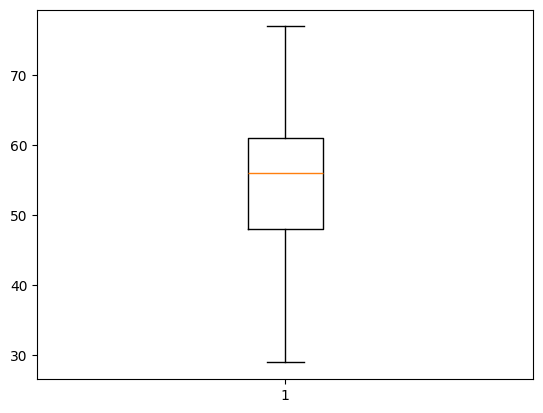

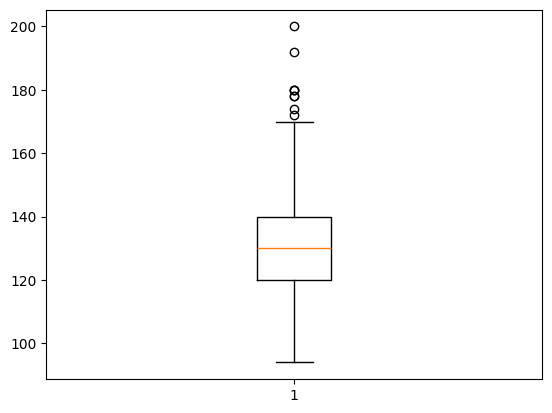

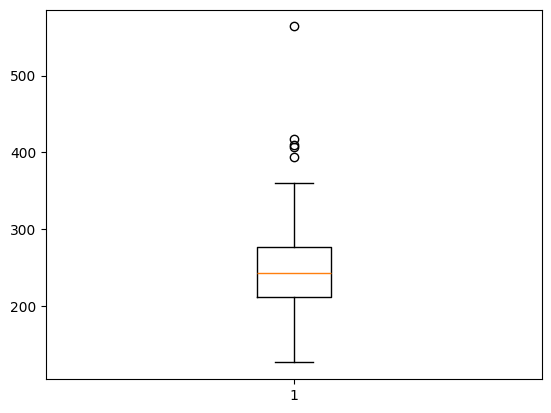

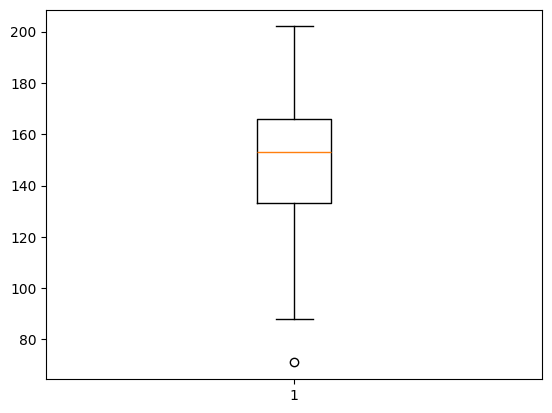

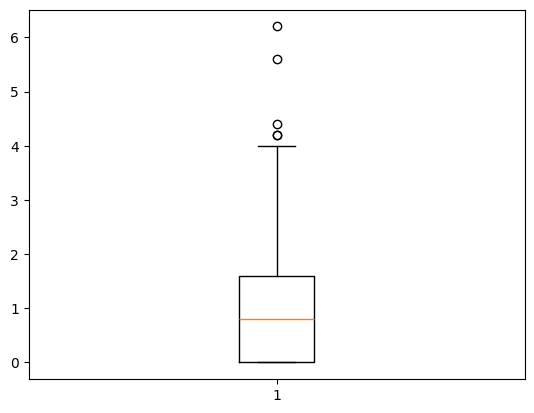

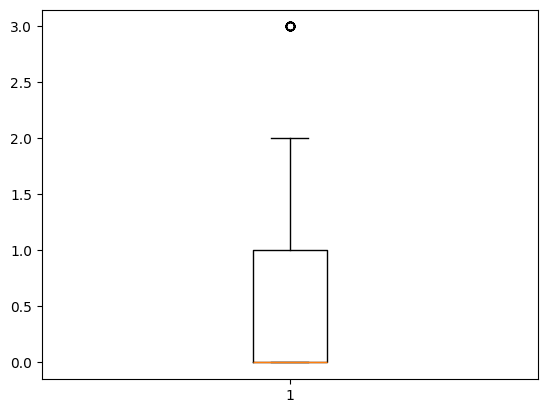

In [36]:
# checking for outliers

plt.boxplot(df['age'])
plt.show()

plt.boxplot(df['trestbps'])
plt.show()

plt.boxplot(df['chol'])
plt.show()

plt.boxplot(df['thalach'])
plt.show()

plt.boxplot(df['oldpeak'])
plt.show()

plt.boxplot(df['ca'])
plt.show()

In [37]:
# Define the columns to check for outliers
columns_to_check = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca']

# Calculate Z-scores for the specified columns
z_scores = np.abs(stats.zscore(df[columns_to_check]))

# Define a Z-score threshold for outlier detection
z_score_threshold = 3

# Identify outliers using the threshold
outliers = (z_scores > z_score_threshold).any(axis=1)

# Display the rows containing outliers
print("Rows with outliers:")

df[outliers]

Rows with outliers:


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
48,65,0,3,140,417,1,2,157,0,0.8,1,1.0,3.0,0
91,62,0,4,160,164,0,2,145,0,6.2,3,3.0,7.0,3
121,63,0,4,150,407,0,2,154,0,4.0,2,3.0,7.0,4
123,55,1,4,140,217,0,0,111,1,5.6,3,0.0,7.0,3
126,56,0,4,200,288,1,2,133,1,4.0,3,2.0,7.0,3
152,67,0,3,115,564,0,2,160,0,1.6,2,0.0,7.0,0
181,56,0,4,134,409,0,2,150,1,1.9,2,2.0,7.0,2
188,54,1,2,192,283,0,2,195,0,0.0,1,1.0,7.0,1
245,67,1,4,120,237,0,0,71,0,1.0,2,0.0,3.0,2


In [38]:
# There are columns with outliers and so removing these outliers

In [39]:
# Removing outliers

df = df[~ outliers]

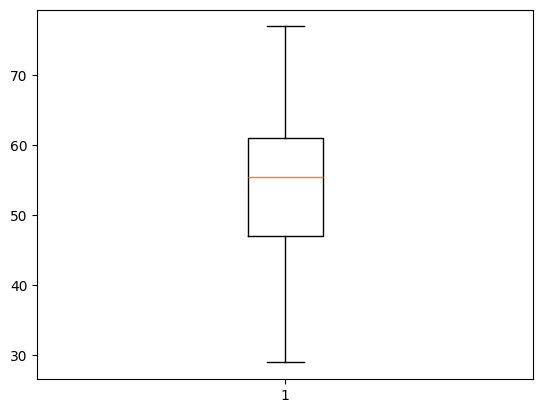

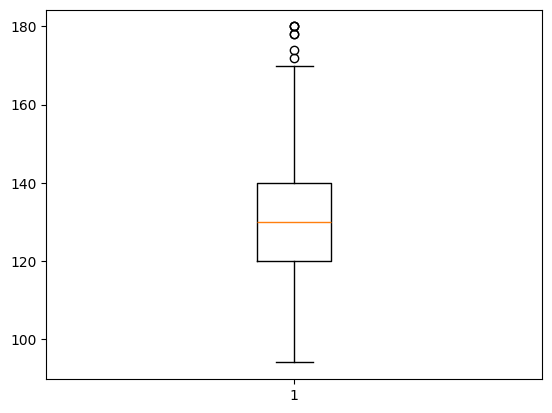

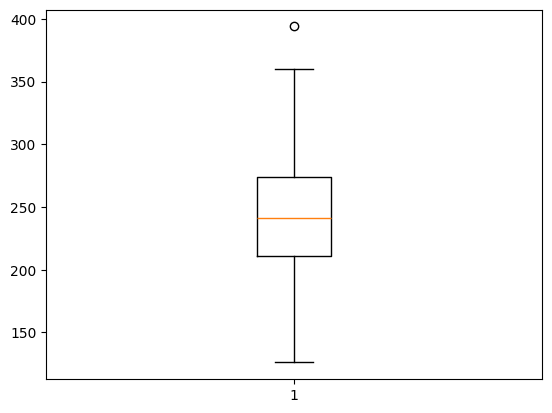

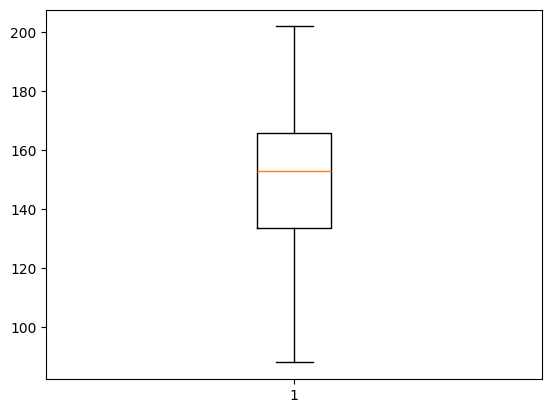

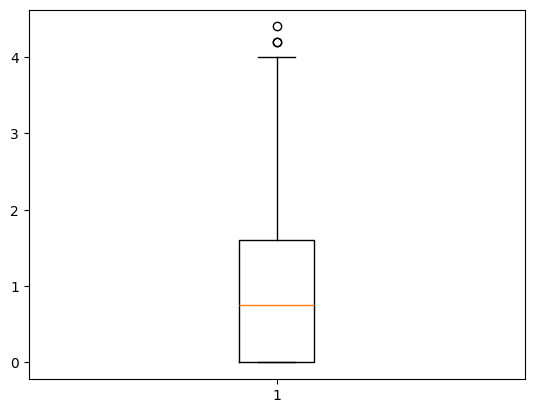

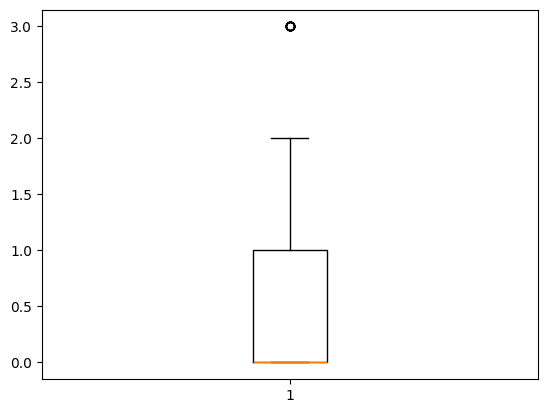

In [40]:
# plotting after removing the outliers

plt.boxplot(df['age'])
plt.show()

plt.boxplot(df['trestbps'])
plt.show()

plt.boxplot(df['chol'])
plt.show()

plt.boxplot(df['thalach'])
plt.show()

plt.boxplot(df['oldpeak'])
plt.show()

plt.boxplot(df['ca'])
plt.show()

#### Using a Naive Bayes classifier to predict the heart disease

In [41]:
# Define features (X) and target variable (y)
X = df.drop(columns=['num'])  # All columns except 'num'
y = df['num']  # Target variable

# Identify categorical columns
categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
continuous_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

# Convert categorical columns to string type before encoding
X[categorical_cols] = X[categorical_cols].astype(str)

# One-hot encoding for categorical features
X_encoded = pd.get_dummies(X, drop_first=True)

# Split data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, stratify = y, random_state=42)

# Train Naïve Bayes Classifier
nb_classifier = GaussianNB()  # Use GaussianNB for mixed (continuous + categorical) data
nb_classifier.fit(X_train, y_train)

# Make predictions
y_pred = nb_classifier.predict(X_test)

# Evaluate the model
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy Score: 0.2413793103448276

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.38      0.52        32
           1       0.00      0.00      0.00        11
           2       0.40      0.29      0.33         7
           3       0.00      0.00      0.00         6
           4       0.00      0.00      0.00         2

    accuracy                           0.24        58
   macro avg       0.25      0.13      0.17        58
weighted avg       0.52      0.24      0.33        58


Confusion Matrix:
 [[12  1  0  1 18]
 [ 1  0  1  0  9]
 [ 0  0  2  1  4]
 [ 0  0  1  0  5]
 [ 1  0  1  0  0]]


Since Gaussian Naive Bayes works well for only Continuous variables we are using a hybrid approach of gaussian Naive Bayes and categorical Naive Bayes as our data has both Continuous and categorical variables

In [42]:
# Define categorical and continuous columns
categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
continuous_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

# Convert categorical variables to integer encoding (for CategoricalNB)
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))  # Convert to string first to prevent float issues
    label_encoders[col] = le  # Store encoders for potential inverse transformation

# Define Features (X) and Target (y)
X = df.drop(columns=['num'])  # Features
y = df['num'].astype(int)  # Target variable must be integer

# Split data into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y, random_state=42)

# Standardize only continuous features for GaussianNB
scaler = PowerTransformer()
X_train[continuous_cols] = scaler.fit_transform(X_train[continuous_cols])
X_test[continuous_cols] = scaler.transform(X_test[continuous_cols])

# Initialize Naïve Bayes models
gnb = GaussianNB()
cat_nb = CategoricalNB()

# Fit models separately for continuous and categorical features
gnb.fit(X_train[continuous_cols], y_train)
cat_nb.fit(X_train[categorical_cols], y_train)

# Predict probabilities from both models
probs_gnb = gnb.predict_proba(X_test[continuous_cols])
probs_catnb = cat_nb.predict_proba(X_test[categorical_cols])

# Ensure probabilities are of the same shape before averaging
if probs_gnb.shape == probs_catnb.shape:
    final_probs = (probs_gnb + probs_catnb) / 2
else:
    raise ValueError("Mismatch in probability shapes. Check input features.")

# Get final predictions
final_preds = np.argmax(final_probs, axis=1)

# Evaluate the model
print("Hybrid Naïve Bayes Accuracy:", accuracy_score(y_test, final_preds))
print("\nClassification Report:\n", classification_report(y_test, final_preds))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, final_preds))


Hybrid Naïve Bayes Accuracy: 0.6724137931034483

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.97      0.85        32
           1       0.20      0.09      0.12        11
           2       0.44      0.57      0.50         7
           3       1.00      0.50      0.67         6
           4       0.00      0.00      0.00         2

    accuracy                           0.67        58
   macro avg       0.48      0.43      0.43        58
weighted avg       0.61      0.67      0.62        58


Confusion Matrix:
 [[31  1  0  0  0]
 [ 8  1  2  0  0]
 [ 1  2  4  0  0]
 [ 1  1  1  3  0]
 [ 0  0  2  0  0]]


After using the Hybrid approach our accuracy has improved to 67.24% without using smoothing techniques


Class Distribution:
target
0    160
1     54
2     35
3     35
4     13
Name: count, dtype: int64

Computed Class Priors: [0.1814346  0.54008439 0.11814346 0.04219409 0.11814346]

=== Hybrid Naïve Bayes Multi-Class Classification Performance ===
Accuracy: 0.6333333333333333

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.97      0.90        32
           1       0.27      0.55      0.36        11
           2       1.00      0.14      0.25         7
           3       0.00      0.00      0.00         7
           4       0.00      0.00      0.00         3

    accuracy                           0.63        60
   macro avg       0.42      0.33      0.30        60
weighted avg       0.61      0.63      0.58        60


Confusion Matrix:
 [[31  1  0  0  0]
 [ 5  6  0  0  0]
 [ 0  6  1  0  0]
 [ 1  6  0  0  0]
 [ 0  3  0  0  0]]


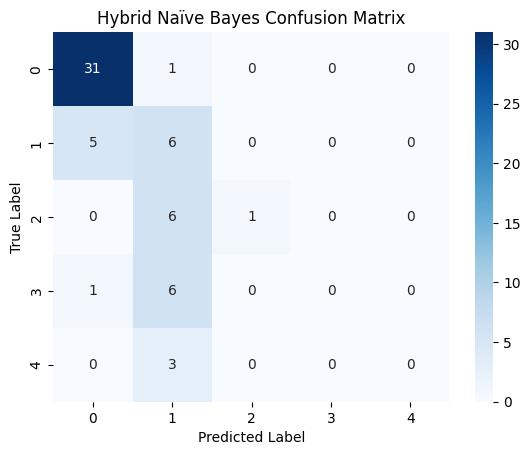

In [43]:
# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Load dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
columns = [
    "age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach",
    "exang", "oldpeak", "slope", "ca", "thal", "target"
]

df = pd.read_csv(url, names=columns, na_values="?")

# Drop missing values
df.dropna(inplace=True)

# Define categorical and continuous columns
categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
continuous_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

# Convert categorical variables to integer encoding (for CategoricalNB)
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))  # Convert to string first to prevent float issues
    label_encoders[col] = le  # Store encoders for potential inverse transformation

# Multi-Class Target (Keep Original Classes)
df['target'] = df['target'].astype(int)  # Ensure integer labels

# Class Distribution Check
print("\nClass Distribution:")
print(df["target"].value_counts())

#  Stratified Train-Test Split (Ensures Class Balance)
X = df.drop(columns=["target"])
y = df["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Apply Power Transformation (Normalize continuous features for GaussianNB)
scaler = PowerTransformer()
X_train[continuous_cols] = scaler.fit_transform(X_train[continuous_cols])
X_test[continuous_cols] = scaler.transform(X_test[continuous_cols])

# Discretization for CategoricalNB (Convert continuous features into bins)
discretizer = KBinsDiscretizer(n_bins=4, encode="ordinal", strategy="uniform")
X_train[continuous_cols] = discretizer.fit_transform(X_train[continuous_cols])
X_test[continuous_cols] = discretizer.transform(X_test[continuous_cols])

# Compute Class Weights for GaussianNB (Handles Class Imbalance)
class_counts = Counter(y_train)
total_samples = sum(class_counts.values())
class_priors = {cls: count / total_samples for cls, count in class_counts.items()}  # Compute priors

# Convert class priors to a list for GaussianNB
prior_values = np.array(list(class_priors.values()))

print("\nComputed Class Priors:", prior_values)

# Train Naïve Bayes Models
gnb = GaussianNB(priors=prior_values)  # Apply class priors for implicit weighting
cat_nb = CategoricalNB(alpha=0.01)  # Apply Laplace Smoothing

gnb.fit(X_train[continuous_cols], y_train)
cat_nb.fit(X_train[categorical_cols], y_train)

# Predict probabilities from both models
probs_gnb = gnb.predict_proba(X_test[continuous_cols])
probs_catnb = cat_nb.predict_proba(X_test[categorical_cols])

# Weighted Probability Fusion (More Confidence on Better Model)
# Instead of simple averaging, weight based on per-class F1-score
classwise_f1_gnb = classification_report(y_test, gnb.predict(X_test[continuous_cols]), output_dict=True)
classwise_f1_catnb = classification_report(y_test, cat_nb.predict(X_test[categorical_cols]), output_dict=True)

# Compute class-wise weights based on F1-score (prevent zero division)
weights_gnb = np.array([classwise_f1_gnb[str(cls)]['f1-score'] for cls in np.unique(y_test)])
weights_catnb = np.array([classwise_f1_catnb[str(cls)]['f1-score'] for cls in np.unique(y_test)])

# Normalize weights to sum to 1
weights_gnb /= weights_gnb.sum()
weights_catnb /= weights_catnb.sum()

# Compute final weighted probability
final_probs = (weights_gnb * probs_gnb) + (weights_catnb * probs_catnb)

#Get final predictions
final_preds = np.argmax(final_probs, axis=1)

#Evaluate the model
print("\n=== Hybrid Naïve Bayes Multi-Class Classification Performance ===")
print("Accuracy:", accuracy_score(y_test, final_preds))
print("\nClassification Report:\n", classification_report(y_test, final_preds))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, final_preds))

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.show()

plot_confusion_matrix(y_test, final_preds, "Hybrid Naïve Bayes Confusion Matrix")


After trying the smoothing techniques also the accuracy is still 0.63 and it didn't improve. So, the model's accuracy is not due to zero probabilities due to unseen categorical values.

In [44]:
#pip install pgmpy


Trying Bayesian Network

The Prime difference between Bayesian Network and the Naive Bayes is Naive Bayes assumes independency between the predictor variables whereas bayesian network works better with the dependencies which works well in the real word data


Final Selected Features: ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

 Bayesian Network couldn't make any predictions! Using a fallback approach.

=== Bayesian Network Multi-Class Classification Performance (Optimized) ===
Accuracy  : 0.5333
Precision : 0.1067
Recall    : 0.2000
F1 Score  : 0.1391

Classification Report:
               precision    recall  f1-score   support

           0       0.53      1.00      0.70        32
           1       0.00      0.00      0.00        11
           2       0.00      0.00      0.00         7
           3       0.00      0.00      0.00         7
           4       0.00      0.00      0.00         3

    accuracy                           0.53        60
   macro avg       0.11      0.20      0.14        60
weighted avg       0.28      0.53      0.37        60



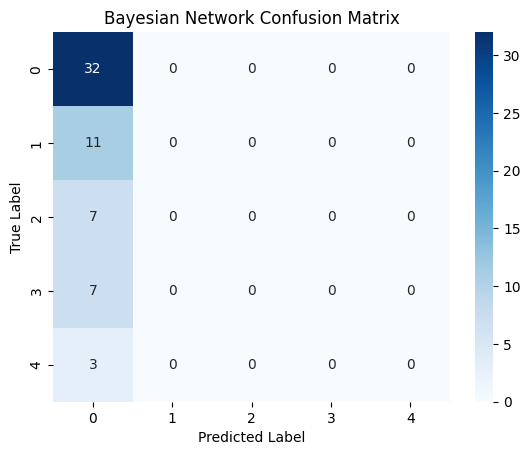

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, PowerTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import BayesianEstimator
from pgmpy.inference import VariableElimination
from sklearn.feature_selection import SelectKBest, f_classif

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# **Step 1: Load Dataset**
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
columns = [
    "age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach",
    "exang", "oldpeak", "slope", "ca", "thal", "target"
]

df = pd.read_csv(url, names=columns, na_values="?")

# Drop missing values (prevents excessive computation)
df.dropna(inplace=True)

# Convert categorical variables to integer encoding
categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# Ensure multi-class target is in integer format
df['target'] = df['target'].astype(int)

# **Step 2: Feature Selection (Reducing Memory Load)**
X = df.drop(columns=["target"])
y = df["target"]

# Select top 5 continuous features based on ANOVA F-score
continuous_cols = ["age", "trestbps", "chol", "thalach", "oldpeak"]
selector = SelectKBest(score_func=f_classif, k=min(5, len(continuous_cols)))
X_selected = selector.fit_transform(X[continuous_cols], y)
selected_continuous = X[continuous_cols].columns[selector.get_support()]

# Combine selected continuous features + all categorical features
selected_features = list(selected_continuous) + categorical_cols
X = X[selected_features]

print("\nFinal Selected Features:", selected_features)

# **Step 3: Train-Test Split (Stratified)**
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# **Step 4: Normalize Continuous Features for Stability**
scaler = PowerTransformer()
X_train[selected_continuous] = scaler.fit_transform(X_train[selected_continuous])
X_test[selected_continuous] = scaler.transform(X_test[selected_continuous])

# **Step 5: Define Bayesian Network Structure (Reducing Complexity)**
bayes_model = BayesianNetwork([
    ("age", "target"), ("cp", "target"), ("chol", "target"),
    ("thal", "target"), ("sex", "cp")
])  # Fewer edges to reduce memory load

# Convert DataFrame for Bayesian Network
df_bayes_train = X_train.copy()
df_bayes_train["target"] = y_train  # Add target variable

# **Step 6: Train Bayesian Network with Bayesian Estimator**
bayes_model.fit(df_bayes_train, estimator=BayesianEstimator)

# **Step 7: Perform Bayesian Inference**
inference = VariableElimination(bayes_model)

# **Step 8: Function to Get Predictions from Bayesian Network**
def predict_bayesian_network(df_test, model, target_var="target"):
    predictions = []
    for _, row in df_test.iterrows():
        evidence = row.drop(target_var).to_dict()
        try:
            pred = inference.map_query(variables=[target_var], evidence=evidence)
            predictions.append(pred[target_var])
        except:
            predictions.append(np.nan)  # Handle missing predictions safely
    return np.array(predictions)

# **Step 9: Prepare Test Data for Bayesian Network**
df_test_bayes = X_test.copy()
df_test_bayes["target"] = y_test.values  # Add target variable

# **Step 10: Get Predictions**
y_pred_bayes = predict_bayesian_network(df_test_bayes, bayes_model)

# **Step 11: Handle NaN Predictions by Assigning Most Common Class**
if np.isnan(y_pred_bayes).all():
    print("\n Bayesian Network couldn't make any predictions! Using a fallback approach.")
    y_pred_bayes[:] = np.argmax(np.bincount(y_test))

# Fill NaN predictions with most frequent class to prevent crashes
y_pred_bayes = np.nan_to_num(y_pred_bayes, nan=np.argmax(np.bincount(y_test)))

valid_indices = ~np.isnan(y_pred_bayes)
y_pred_bayes = y_pred_bayes[valid_indices]
y_test_bayes = y_test[valid_indices]

# **Step 12: Evaluate Bayesian Network**
if len(y_pred_bayes) > 0:
    print("\n=== Bayesian Network Multi-Class Classification Performance (Optimized) ===")
    print(f"Accuracy  : {accuracy_score(y_test_bayes, y_pred_bayes):.4f}")
    print(f"Precision : {precision_score(y_test_bayes, y_pred_bayes, average='macro', zero_division=0):.4f}")
    print(f"Recall    : {recall_score(y_test_bayes, y_pred_bayes, average='macro', zero_division=0):.4f}")
    print(f"F1 Score  : {f1_score(y_test_bayes, y_pred_bayes, average='macro', zero_division=0):.4f}")
    print("\nClassification Report:\n", classification_report(y_test_bayes, y_pred_bayes))

# **Step 13: Plot Confusion Matrix**
def plot_bayesian_confusion_matrix(y_true, y_pred, title="Bayesian Network Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.show()

plot_bayesian_confusion_matrix(y_test_bayes, y_pred_bayes)
